# Validación cruzada
---

In [1]:
import pandas as pd
df = pd.read_csv('https://bit.ly/3gob0mX', header = None)
display(df.head(2), df.tail(2))

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.3514,0.152,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.265,0.4087,0.12400
568,92751,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.0000,0.000,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.000,0.2871,0.07039


In [2]:
from sklearn.preprocessing import LabelEncoder
# Preprocesamiento 
X, y = df.iloc[:, 2:].values, df.iloc[:, 1]. values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_, le.transform(['B', 'M'])

(array(['B', 'M'], dtype=object), array([0, 1]))

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 1)

In [4]:
# Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components = 2),
                        LogisticRegression(random_state = 1)) # Todo lo que usa debe tener métodos fit, transform o predict
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Exactitud (test): %.3f' % pipe_lr.score(X_test, y_test))

Exactitud (test): 0.956


In [5]:
# Validación cruzada con k-pliegues
import numpy as np
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits = 10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train]) # train son los índices de entrenamiento
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Pliegue %2d: \nDist por clase: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

Pliegue  1: 
Dist por clase: [256 153], Acc: 0.935
Pliegue  2: 
Dist por clase: [256 153], Acc: 0.935
Pliegue  3: 
Dist por clase: [256 153], Acc: 0.957
Pliegue  4: 
Dist por clase: [256 153], Acc: 0.957
Pliegue  5: 
Dist por clase: [256 153], Acc: 0.935
Pliegue  6: 
Dist por clase: [257 153], Acc: 0.956
Pliegue  7: 
Dist por clase: [257 153], Acc: 0.978
Pliegue  8: 
Dist por clase: [257 153], Acc: 0.933
Pliegue  9: 
Dist por clase: [257 153], Acc: 0.956
Pliegue 10: 
Dist por clase: [257 153], Acc: 0.956


In [6]:
print('Exactitud de la CV: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Exactitud de la CV: 0.950 +/- 0.014


In [7]:
# CV de sklearn
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator = pipe_lr, X = X_train, y = y_train, cv = 10, n_jobs = 1) # n_jobs sirve para procesamiento en paralelo. '-1' le indica que debe usar todos los núcleos en la arquitectura.
print('Puntajes de CV %s' % (scores))
print('Exactitud de la CV: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Puntajes de CV [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
Exactitud de la CV: 0.950 +/- 0.014


In [8]:
# Curvas de aprendizaje
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = make_pipeline(StandardScaler(),
                       LogisticRegression(penalty = 'l2', random_state = 1))
train_sizes, train_scores, test_scores = learning_curve(estimator = pipe_lr, X = X_train, y = y_train, train_sizes = np.linspace(0.1, 1, 10),  cv = 10, n_jobs = 1)

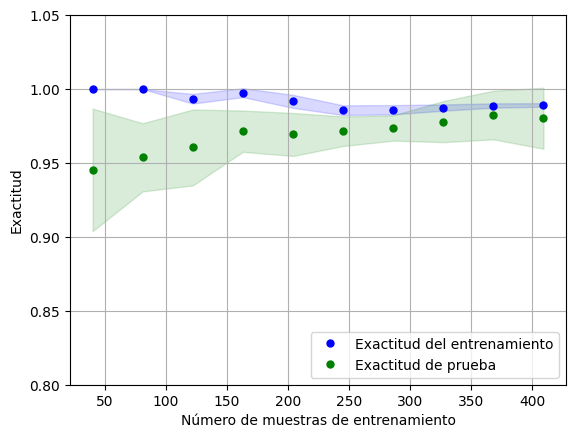

In [9]:
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)
plt.plot(train_sizes, train_mean, 'bo', markersize = 5, label = 'Exactitud del entrenamiento')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, color = 'b', alpha = 0.15)
plt.plot(train_sizes, test_mean, 'go', markersize = 5, label = 'Exactitud de prueba')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, color = 'g', alpha = 0.15)
plt.grid()
plt.xlabel('Número de muestras de entrenamiento')
plt.ylabel('Exactitud')
plt.ylim([0.8, 1.05])
plt.legend(loc = 'lower right')
plt.show()

In [10]:
# Curva de validación
from sklearn.model_selection import validation_curve
range_ = [10**i for i in range(-3, 3)]
train_scores, test_scores = validation_curve(estimator = pipe_lr, X = X_train, y = y_train, param_name = 'logisticregression__C', # nombredelmodeloenminusculas__parametro (doble guión bajo)
                                             param_range = range_, cv = 10, n_jobs = 1)

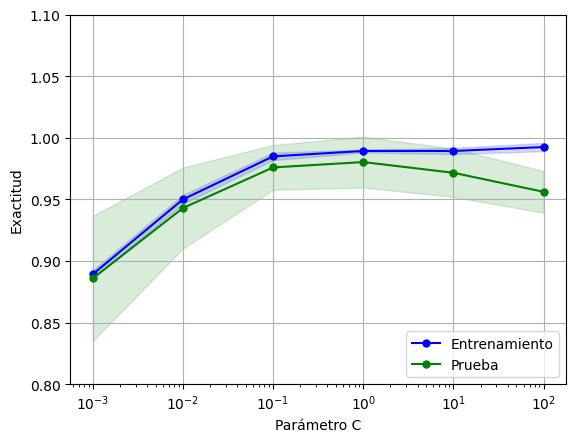

In [11]:
train_mean, train_std = np.mean(train_scores, axis = 1), np.std(train_scores, axis = 1)
test_mean, test_std = np.mean(test_scores, axis = 1), np.std(test_scores, axis = 1)
plt.plot(range_, train_mean, color = 'blue', marker = 'o', markersize = 5, label = 'Entrenamiento')
plt.fill_between(range_, train_mean + train_std, train_mean - train_std, color = 'blue', alpha = 0.15)
plt.plot(range_, test_mean, color = 'green', marker = 'o', markersize = 5, label = 'Prueba')
plt.fill_between(range_, test_mean + test_std, test_mean - test_std, color = 'green', alpha = 0.15)
plt.xscale('log')
plt.xlabel('Parámetro C')
plt.ylabel('Exactitud') 
plt.legend(loc = 'lower right')
plt.ylim([0.8, 1.1])
plt.grid()
plt.show()

In [14]:
# Ajuste fino con búsqueda de malla
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC # Clasificador
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state = 1))
grid_svc = [{'svc__C': range_, 'svc__kernel': ['linear']},
            {'svc__C': range_, 'svc__kernel': ['rbf'], 'svc__gamma': range_}]
gs = GridSearchCV(estimator = pipe_svc, param_grid = grid_svc, scoring = 'accuracy', cv = 10, n_jobs = 1)
gs = gs.fit(X_train, y_train)

In [16]:
display(gs.best_score_, gs.best_params_)

np.float64(0.9846859903381642)

{'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

In [19]:
# Exactitud del mejor modelo
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Exactitud en test: %.3f' % clf.score(X_test, y_test)) # Notamos tiene buen rendimiento, no está sobreentrenado

Exactitud en test: 0.974


*Tarea*: Se recomienda revisar y copiar línea por línea (para mejor comprensión) el ejemplo de <a href="https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html">Scikit Learn</a>


In [21]:
# Selección de algoritmos con CVGS (validación cruzada con búsqueda de malla) anidada
gs = GridSearchCV(estimator = pipe_svc, param_grid = grid_svc, scoring = 'accuracy', cv = 2)
scores = cross_val_score(gs, X_train, y_train, scoring = 'accuracy', cv = 5)

In [24]:
print('Exactitud de NCV (Nest Cross Validation) con SVC: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Exactitud de NCV (Nest Cross Validation) con SVC: 0.974 +/- 0.015


In [27]:
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 42),
                  param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring = 'accuracy', cv = 2)
scores = cross_val_score(gs, X_train, y_train, scoring = 'accuracy', cv = 5)
print('Exactitud de NCV (Nest Cross Validation) con DTC: %.3f +/- %.3f' % (np.mean(scores), np.std(scores))) # Es mas conveniente usar la máquina de soporte vectorial

Exactitud de NCV (Nest Cross Validation) con DTC: 0.932 +/- 0.022


In [31]:
import warnings
warnings.filterwarnings('ignore') # Para ignorar errors de no convergencia
pipe_lr = make_pipeline(StandardScaler(), 
                        LogisticRegression(penalty = 'l2', random_state = 1))
param_grid_lr = [{'logisticregression__C': range_,
                 'logisticregression__solver': ['lbfgs', 'linear', 'newton_cg', 'newton-cholesky', 'sag', 'saga']}] # Con range_ a veces no converge: Se puede modificar el máximo de iteraciones. Consultar decumentación
gs = GridSearchCV(estimator = pipe_lr,
                  param_grid = param_grid_lr,
                  scoring = 'accuracy', cv = 2)
scores = cross_val_score(gs, X_train, y_train, scoring = 'accuracy', cv = 5)
print('Exactitud de NCV (Nest Cross Validation) con Regresión Logística: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Exactitud de NCV (Nest Cross Validation) con Regresión Logística: 0.969 +/- 0.016


In [34]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
display(confmat)

array([[71,  1],
       [ 2, 40]])

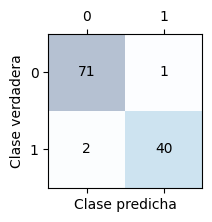

In [36]:
fig, ax = plt.subplots(figsize = (2,2))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j, y = i, s = confmat[i, j],
                va = 'center', ha = 'center')
plt.xlabel('Clase predicha')
plt.ylabel('Clase verdadera')
plt.show()

*Tarea:* Investiga dentro de Scikit Learn como graficar automáticamente la matriz de confusión.